In [1]:
%cd ~/cdv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rho_plus as rp

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import jax
import jax.numpy as jnp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)

/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/nmiklaucic/cdv


In [2]:
dfs = []
models = ['enb-197', 'enb-198', 'enb-199']
for model in models:
    for split in ('train', 'valid', 'test'):
        dfs.append(pd.read_feather(f'data/{model}_{split}.feather'))
        dfs[-1]['split'] = split
        dfs[-1]['model'] = model

df = pd.concat(dfs).reset_index()
df['split'] = pd.Categorical(df['split'], categories=['train', 'valid', 'test'], ordered=True)
df['model'] = pd.Categorical(df['model'])

df.shape

(4741464, 6)

In [3]:
pivoted = df.pivot_table(index=['index', 'split'], columns='model', values=['prediction', 'target'], observed=False)
pivoted.columns = models + ['target'] + ['target2'] * (len(models) - 1)
pivoted.drop(columns=['target2'], inplace=True)
pivoted

enb-197   enb-198   enb-199    target
index   split                                        
0       train -7.450242 -7.446835 -7.451971 -7.449115
        valid -4.543889 -4.527889 -4.576456 -4.560117
        test  -6.615935 -6.616247 -6.609588 -6.616924
1       train -8.074464 -8.072561 -8.073508 -8.068948
        valid -3.482732 -3.422691 -3.483650 -3.444715
...                 ...       ...       ...       ...
1314487 train -4.200040 -4.237227 -4.214700 -4.113819
1314488 train -7.813198 -7.824353 -7.822027 -7.813792
1314489 train -9.255919 -9.282350 -9.261489 -9.289242
1314490 train -6.490796 -6.450808 -6.500042 -6.486058
1314491 train -9.395794 -9.441685 -9.472312 -9.356917

[1580488 rows x 4 columns]

In [14]:
pivoted['mean'] = pivoted[models].mean(axis=1)

In [17]:
((pivoted - pivoted[['target']].values).abs().mean(axis=0) * 1000).round(2).to_frame()

,0
enb-197,15.35
enb-198,15.67
enb-199,15.50
target,0.00
mean,12.97


In [19]:
res_df = ((pivoted - pivoted[['target']].values).abs().groupby('split').mean() * 1000).round(2)

res_df.loc['all', :] = ((pivoted - pivoted[['target']].values).abs().mean(axis=0) * 1000).round(2).T
res_df

/tmp/ipykernel_429826/2646053960.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res_df = ((pivoted - pivoted[['target']].values).abs().groupby('split').mean() * 1000).round(2)


,enb-197,enb-198,enb-199,target,mean
split,,,,,
train,12.78,13.13,12.98,0.0,10.77
valid,28.58,29.13,28.72,0.0,24.64
test,27.53,27.38,27.23,0.0,23.11
all,15.35,15.67,15.50,0.0,12.97


In [10]:
270383 * 3

811149

In [5]:
np.mean(np.abs(target - ensemble['enb-197']))

0.013220107364214242

In [11]:
from facet.data.dataset_generation import parse_data_id_mptrj


parse_data_id_mptrj(df['dataset_id'][4])

'mp-556783-1-3'

In [12]:
df['err'] = df.eval('target - prediction')
df['abs_err'] = np.abs(df['err'])

worst = df.sort_values('abs_err', ascending=False).head(30)
worst.head()

,dataset_id,target,prediction,split,model,err,abs_err
1152873,1936295000,-1.809825,-7.621657,train,enb-183,5.811832,5.811832
2733361,1936295000,-1.809825,-7.621657,train,enb-197,5.811832,5.811832
2744061,-1365746880,-4.238377,-9.050261,train,enb-197,4.811885,4.811885
1163573,-1365746880,-4.238377,-9.050261,train,enb-183,4.811885,4.811885
1368686,1555394000,-3.590962,-8.203356,valid,enb-183,4.612394,4.612394


In [ ]:
df.groupby(['model', 'dataset_id']).mean(numeric_only=True)

/tmp/ipykernel_404552/1019965449.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['model', 'dataset_id']).std(numeric_only=True)


target  prediction       err   abs_err
model   dataset_id                                           
enb-183 -1883890888       NaN         NaN       NaN       NaN
        -1883890886  0.098067    0.057520  0.080796  0.080796
        -1883890885  0.266137    0.224026  0.042112  0.042112
        -1883890884  0.014991    0.041049  0.026058  0.026058
        -1883890880       NaN         NaN       NaN       NaN
...                       ...         ...       ...       ...
enb-197  1999566005       NaN         NaN       NaN       NaN
         1999576000  0.117367    0.004895  0.115926  0.066890
         1999576001       NaN         NaN       NaN       NaN
         1999576002  0.233464    0.219452  0.014012  0.014012
         1999576003  0.005275    0.008454  0.003179  0.003179

[2534578 rows x 4 columns]

In [5]:
from sklearn.metrics import r2_score

r2_score(df['prediction'], df['target'])

0.9991213586622706

In [8]:
df.groupby('split').mean(numeric_only=True)['abs_err'].round(5) * 1000

/tmp/ipykernel_404552/3418772384.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('split').mean(numeric_only=True)['abs_err'].round(5) * 1000


split
train    23.36
valid    33.61
test     32.12
Name: abs_err, dtype: float64

In [43]:
df['abs_err'].mean().round(5) * 1000

24.96

In [30]:
worst_ds_ids = [parse_data_id_mptrj(x) for x in worst['dataset_id']]
worst_mp_ids = [s.rsplit('-', maxsplit=2)[0] for s in worst_ds_ids if s.startswith('mp')]
worst_mp_ids

['mp-936295',
 'mp-555394',
 'mp-614724',
 'mp-694932',
 'mp-694932',
 'mp-807421',
 'mp-887457',
 'mp-808843',
 'mp-988484',
 'mp-693892',
 'mp-734306',
 'mp-723973',
 'mp-722050',
 'mp-807730',
 'mp-807825',
 'mp-877684',
 'mp-936895',
 'mp-785008']

In [36]:
from mp_api.client import MPRester

with MPRester() as mpr:
    docs = mpr.materials.summary.search(material_ids=worst_mp_ids)

Retrieving SummaryDoc documents:   0%|          | 0/18 [00:00<?, ?it/s]

In [54]:
[doc.composition.to_pretty_string() for doc in docs]

['Na2Co6O12',
 'Li4Mn2V2P8O28',
 'Li4Mn1V3P8O28',
 'V2O3F3',
 'Si8Ag20O26',
 'Sr8Cr4Cl4O16',
 'Na4Te4H8O14',
 'Sc4Se6',
 'C4Br2N2O2',
 'Li2V4P8H4O32',
 'Li2V4P8H4O32',
 'K3Li3Sb9O24',
 'Ta22O4',
 'Si16O32',
 'Cs6Cr2F14',
 'Na2Co6O12',
 'V1Fe2Se4',
 'La9Er1O15']

<Axes: xlabel='err', ylabel='Count'>

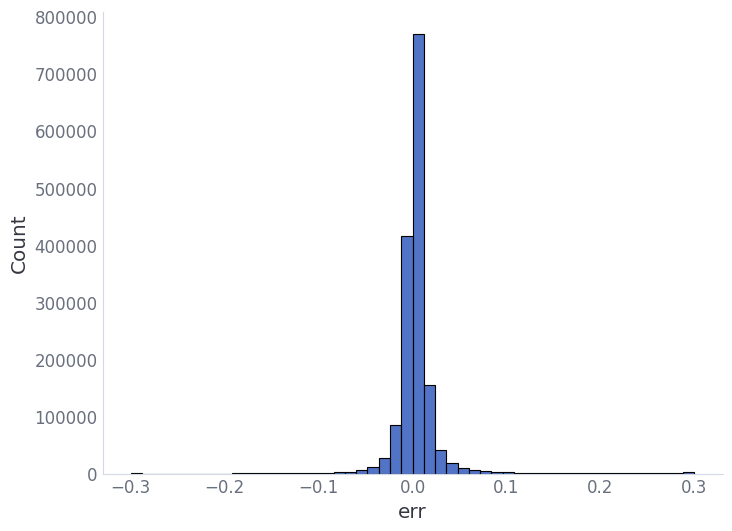

In [37]:
sns.histplot(df['err'].clip(-0.3, 0.3), bins=50)

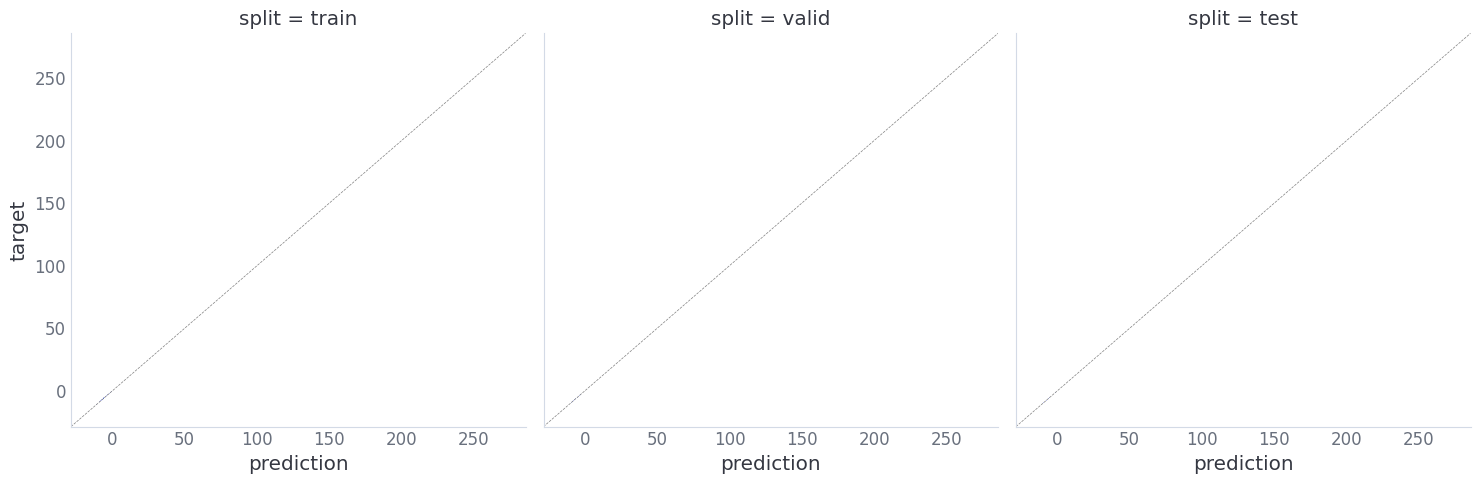

In [ ]:
g = sns.displot(df, x='prediction', y='target', col='split')

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

newmin, newmax = min(xmin, ymin), max(xmax, ymax)

plt.xlim(newmin, newmax)
plt.ylim(newmin, newmax)

for ax in g.axes.flatten():
    ax.axline((0, 0), slope=1, ls='--', lw=0.5, color='grey')